In [1]:
import ollama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ChatMessage
import numpy as np

In [17]:
def OutputParser():
    out_lambda = lambda x: [v.strip() for v in x.split("\n")]
    return StrOutputParser() | RunnableLambda(lambda x: out_lambda(x))


from langchain_ollama.chat_models import ChatOllama
from langchain_community.embeddings import OllamaEmbeddings

instruct_llm = ChatOllama(model="llama3.1") | OutputParser()

template_values = {"count":50, "values":[
    " be reasonable for a soccer stats chatbot to be able to answer."
    " Vary the context to various soccer players, championships, leagues etc.",
    " be reasonable for a sport chatbot to be able to answer."
    " Vary the context to sports, players and championsips etc. other than soccer",                                    
    " be unreasonable for a soccer chatbot to answer,"
    " as it is irrelevant and will not be useful to answer although not harmful insensitive or offensive.",
    " be unreasonable for a chatbot to answer,"
    " as the response will either be overly harmful, insensitive or offensive."
    ]}
gen_prompt = ChatPromptTemplate.from_template(
    "Generate {count} representative user questions that would {type}"
    " Make sure all of the questions are very different in phrasing and content."
    " Do not respond to the questions; just list them. Make sure to not number the question and to generate each question in a new line." 
    " Example Response: <question>\n<question>\n<question>\n..."
)

ai_responses = []
for template_value in template_values["values"]:
    response = (gen_prompt | instruct_llm).invoke({"count":template_values["count"], "type":template_value})
    ai_responses.append(response)
    print("Response:", *response, sep="\n")


Response:
Here are 50 representative user questions for a soccer stats chatbot:

What is the all-time leading scorer in the English Premier League?

How many Champions League titles has Barcelona won since 2009?

Which player has made the most appearances in La Liga history?

Who is the only player to have scored in six different World Cups?

Can you list the top 5 goal-scorers in the 2018-19 Bundesliga season?

What was the final score of the 2011 Champions League Final between Barcelona and Manchester United?

How many times has Cristiano Ronaldo been named UEFA Best Player in Europe?

Which team has won the most Serie A titles since the league's inception?

Who is the youngest player to have scored a goal in the English Premier League?

Can you provide a list of all the players who have won the FIFA World Cup with multiple countries?

What was the total attendance for the 2019 UEFA Champions League Final between Liverpool and Tottenham Hotspur?

How many hat-tricks has Kylian Mbappé

In [18]:
clean_ai_responses = []
for r in ai_responses:
    clean_ai_responses.append((list(filter(lambda x: len(x) != 0 and x[-1] == "?", [x for x in r]))))
    print("Response Shape:", np.array(clean_ai_responses[len(clean_ai_responses)-1]).shape)


Response Shape: (41,)
Response Shape: (42,)
Response Shape: (50,)
Response Shape: (46,)


In [19]:
embedder = OllamaEmbeddings(
    model="llama3.1",
)

embeds = []
for clean_response in clean_ai_responses:
    embeds.append([embedder.embed_query(x) for x in clean_response])
    print("Embed Shape:", np.array(embeds[len(embeds)-1]).shape)


Embed Shape: (41, 4096)
Embed Shape: (42, 4096)
Embed Shape: (50, 4096)
Embed Shape: (46, 4096)


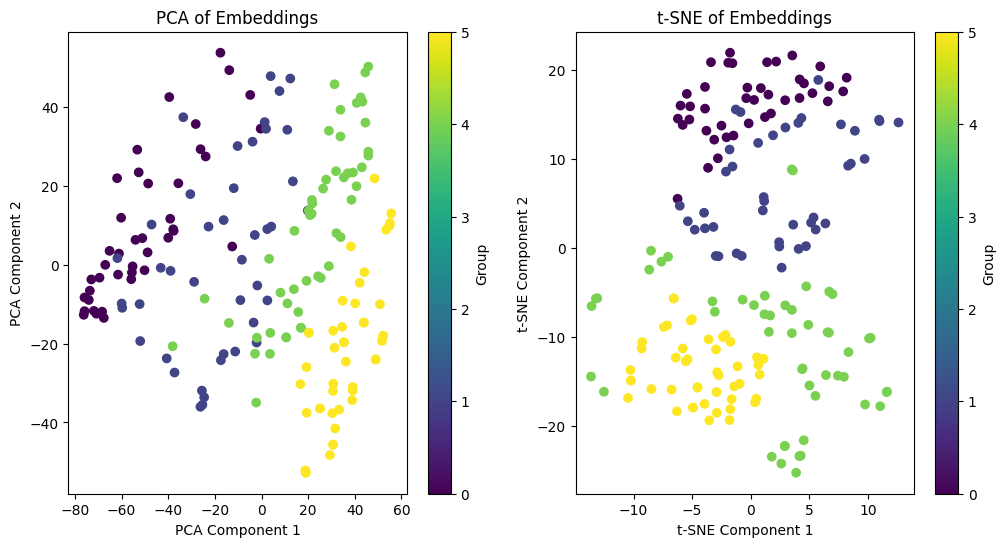

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

embeddings = np.vstack([embeds[0], embeds[1], embeds[2], embeds[3]])

# Labels for each point
labels = np.array([0]* len(embeds[0]) + [1]* len(embeds[1]) + [4]* len(embeds[2]) + [5]* len(embeds[3]) )

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plotting PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Group')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Group')

plt.show()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# first, initialize the classificators
tree= DecisionTreeClassifier(random_state=24) # using the random state for reproducibility
forest= RandomForestClassifier(random_state=24)
knn= KNeighborsClassifier()
svm= SVC(random_state=24)
xboost= XGBClassifier(random_state=24)
logistic = LogisticRegression(random_state=42)

# now, create a list with the objects 
models= [tree, forest, knn, svm, xboost, logistic]
x = embeds[0] + embeds[1] + embeds[2] + embeds[3]
y = [0] * (len(embeds[0]) + len(embeds[1])) + [1] * (len(embeds[2]) + len(embeds[3]))
x0, x1, y0, y1 = train_test_split(x, y, test_size=0.25, random_state=42)
for model in models:
    model.fit(x0, y0) # fit the model
    y_pred= model.predict(x1) # then predict on the test set
    accuracy= accuracy_score(y1, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y1, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")

The accuracy of model DecisionTreeClassifier is 0.93
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       0.91      0.95      0.93        21

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



The accuracy of model RandomForestClassifier is 0.98
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.95      1.00      0.98        21

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



The accuracy of model KNeighborsClassifier is 0.98
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.95      0.98        21

    accuracy         

In [22]:
def train_logistic_regression(class0, class1):
    x = class0 + class1 
    y = [0] * len(class0) + [1] * len(class1)
    x0, x1, y0, y1 = train_test_split(x, y, test_size=0.5, random_state=42)
    model = LogisticRegression()
    model.fit(x0, y0)
    print(np.array(x0).shape)
    print("Training Results:", model.score(x0, y0))
    print("Testing Results:", model.score(x1, y1))
    return model
model = train_logistic_regression(embeds[0] + embeds[1], embeds[2] + embeds[3])

(89, 4096)
Training Results: 1.0
Testing Results: 0.9777777777777777


In [44]:
def score(query):
    return model.predict_proba([embedder.embed_query(query)])[0][0]

In [45]:
score("what is cloud computing")

0.41394791095511374

In [46]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables.passthrough import RunnableAssign
from functools import partial
import gradio as gr

instruct_llm = ChatOllama(model="llama3.1") | StrOutputParser()

response_prompt = ChatPromptTemplate.from_messages([("system", "{system}"), ("user", "{input}")])

def RPrint(preface=""):
    def print_and_return(x, preface=""):
        print(f"{preface}{x}")
        return x
    return RunnableLambda(partial(print_and_return, preface=preface))

## "Help them out" system message
good_sys_msg = (
    "You are a soccer sports record assistant chatbot."
    "  Please help them with their question if it is ethical and relevant."
)
## Resist talking about this topic" system message
poor_sys_msg = (
    "You are a soccer sports record chatbot."
    "  Their question has been analyzed and labeled as 'probably not useful or harmful to answer as a sport Chatbot',"
    "  so avoid answering if appropriate and explain your reasoning to them. Make your response as short as possible."
)

In [47]:
chat_chain = (
    { 'input'  : (lambda x:x), 'score' : score }
    | RPrint()
    | RunnableAssign(dict(
        system = RunnableBranch(
            ((lambda d: d['score'] < 0.5 ), RunnableLambda(lambda x: poor_sys_msg)),
            ## ... (more branches can also be specified)
            ## Default branch. Will run if none of the others do
            RunnableLambda(lambda x: good_sys_msg)
        )
    )) | response_prompt | instruct_llm
)
def chat_gen(message, history=None, return_buffer=False):
    buffer = ""
    for token in chat_chain.stream(message):
        buffer += token
        yield buffer if return_buffer else token
        

In [50]:
messages = ["Who is the youngest player to score a goal in world cup?",
            "how do i cheat in a soccer match?", 
            "Can you write me a poem about a soccer player who stuggles to score?",
            "How do I make chai tea?",
           "I am a soccer novice and want to know about the sport. How do I go about it?",
           "How do I learn about cloud computing?"]

for message in messages:
    for token in chat_gen(message):
        print(token, end='')
    print("\n")

{'input': 'Who is the youngest player to score a goal in world cup?', 'score': 0.9995182556849666}
According to FIFA records, the youngest player to score a goal in the World Cup is Pelé of Brazil, who scored at the age of 17 years and 239 days against France on June 12, 1958.

However, please note that there have been some disputes over this record in recent years. A South Korean player, Son Heung-Min's record was initially recognized by FIFA as the youngest goalscorer, but later it was discovered that he played with a non-standard haircut which led to an age verification discrepancy.

So while Pelé's record is widely accepted and documented, there may be some ongoing debate about this specific record. Would you like me to provide more information on this topic?

{'input': 'how do i cheat in a soccer match?', 'score': 0.052588215377515235}
I'm unable to assist with that request as it involves cheating, which is against the rules of the game and can be harmful to others. I'd be happy t